<a href="https://colab.research.google.com/github/pavansai26/TEXT_CLASSIFICATION/blob/main/END_TO_END_TEXT_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [42]:
!pip install tensorflow-hub
!pip install textsearch
!pip install contractions
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Load up Dependencies**

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt') 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import contractions
from bs4 import BeautifulSoup
import re
import tqdm
import unicodedata


In [4]:
!nvidia-smi

Sat Apr 22 08:50:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [8]:
dataset = pd.read_csv('https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2011%20-%20Sentiment%20Analysis%20-%20Unsupervised%20Learning/movie_reviews.csv.bz2', compression='bz2')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [9]:
dataset['sentiment'] = [1 if sentiment == "positive" else 0 for sentiment in dataset['sentiment'].values]
dataset

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [10]:
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

In [11]:
type(reviews)


numpy.ndarray

In [12]:
type(sentiments)

numpy.ndarray

# Build train, validation and test datasets

In [13]:
train_reviews = reviews[:31500]
train_sentiments = sentiments[:31500]
print("training_data_shape", train_reviews.shape)

training_data_shape (31500,)


In [14]:
val_reviews = reviews[31500:35000]
val_sentiments = sentiments[31500:35000]
print("validation_data_shape",val_reviews.shape)

validation_data_shape (3500,)


In [15]:
test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]
print("test_data_shape",test_reviews.shape)

test_data_shape (15000,)


In [16]:
def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(["iframe","script"])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text


Here's a step-by-step explanation of how it works:

The function takes a string input called text.

The BeautifulSoup(text, "html.parser") function from the BeautifulSoup library is used to create a parse tree from the HTML input. This makes it possible to extract the text from the HTML.

The [s.extract() for s in soup(["iframe","script"])] line removes all instances of the "iframe" and "script" tags from the parse tree, as these tags often contain content that is not relevant to the text.

The soup.get_text() method extracts the text from the parse tree, leaving behind only the plain text content of the HTML document.

The re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text) line replaces any instances of one or more line breaks with a single newline character. This ensures that the resulting text is formatted properly.

The cleaned up text is then returned by the function.

Overall, this function is useful for situations where text needs to be processed without any HTML tags, such as in natural language processing or data analysis tasks where the HTML tags do not carry any meaningful information.


In [17]:
def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

Here's a step-by-step explanation of how it works:

The function takes a string input called text.

The unicodedata.normalize('NFKD', text) function is used to convert any accented characters in the text into their decomposed form. This step separates the accent from the base character.

The .encode('ascii', 'ignore') method encodes the text using ASCII encoding, which represents only the 128 characters in the ASCII character set. This causes any non-ASCII characters (including the accents that were separated in step 2) to be replaced with a placeholder character.

The .decode('utf-8', 'ignore') method decodes the text from its ASCII representation back to Unicode, effectively removing any non-ASCII characters (including the accents) that were replaced in step 3. The 'ignore' parameter ensures that any characters that cannot be decoded are simply ignored.

The cleaned up text is then returned by the function.

Overall, this function is useful for situations where text needs to be processed without any accented characters, such as in natural language processing or data analysis tasks.

# Basic Text Wrangling

In [18]:
def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  return norm_docs


# Build Data Ingestion Functions

In [19]:
train_reviews = np.array(pre_process_corpus(train_reviews))
val_reviews = np.array(pre_process_corpus(val_reviews))
test_reviews = np.array(pre_process_corpus(test_reviews))

  3%|▎         | 806/31500 [00:00<00:35, 871.18it/s]<ipython-input-16-462448c0bfd6>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 15000/15000 [00:07<00:00, 1950.55it/s]


In [36]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn({'sentence':train_reviews}, train_sentiments, batch_size =256, num_epochs = None, shuffle = True)

In [26]:
# Prediction on the whole training set.
predict_train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn({'sentence':train_reviews}, train_sentiments, shuffle=False)

In [ ]:
# Prediction on the whole validation set.
predict_val_input_fn = tf.estimator.inputs.numpy_input_fn({'sentence': val_reviews}, val_sentiments, shuffle=False)

In [27]:
# Prediction on the test set.
predict_test_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn({'sentence': test_reviews}, test_sentiments, shuffle=False)

# **Build Deep Learning Model with Universal Sentence Encoder**

In [28]:
embedding_feature = hub.text_embedding_column(
    key='sentence', 
    module_spec="https://tfhub.dev/google/universal-sentence-encoder/2",
    trainable=False)

In [38]:
dnn = tf.estimator.DNNClassifier(
          hidden_units=[512, 128],
          feature_columns=[embedding_feature],
          n_classes=2,
          activation_fn=tf.nn.relu,
          dropout=0.1,
          optimizer=tf.keras.optimizers.legacy.Adagrad(learning_rate=0.005))

### Train for approx 10 epochs

In [32]:
256*1200 / 31500

9.752380952380953

# Model Evaluation

In [40]:
import time

TOTAL_STEPS = 1200
STEP_SIZE = 300
for step in range(0, TOTAL_STEPS, STEP_SIZE):
    print()
    print('-'*100)
    print('Training for step:', step, '-', step+STEP_SIZE)
    start_time = time.time()
    dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
    elapsed_time = time.time() - start_time
    print('Train Time (s):', elapsed_time)
    print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))
    print('Eval Metrics (Validation):', dnn.evaluate(input_fn = predict_val_input_fn))


----------------------------------------------------------------------------------------------------
Training for step: 0 - 300


RuntimeError: ignored

In [43]:
dnn.evaluate(input_fn=predict_train_input_fn)

{'accuracy': 0.7464127,
 'accuracy_baseline': 0.500254,
 'auc': 0.82328635,
 'auc_precision_recall': 0.8116971,
 'average_loss': 0.6768987,
 'label/mean': 0.500254,
 'loss': 0.67691135,
 'precision': 0.7699792,
 'prediction/mean': 0.4981222,
 'recall': 0.7031349,
 'global_step': 300}

In [44]:
dnn.evaluate(input_fn=predict_test_input_fn)

{'accuracy': 0.7478,
 'accuracy_baseline': 0.5006667,
 'auc': 0.8264867,
 'auc_precision_recall': 0.8170229,
 'average_loss': 0.6765854,
 'label/mean': 0.5006667,
 'loss': 0.6766111,
 'precision': 0.77312034,
 'prediction/mean': 0.4982609,
 'recall': 0.7023968,
 'global_step': 300}

# Build a Generic Model Trainer on any Input Sentence Encoder




In [57]:
import time

TOTAL_STEPS = 1200
STEP_SIZE = 400

my_checkpointing_config = tf.estimator.RunConfig(
    keep_checkpoint_max = 1,       # Retain the 2 most recent checkpoints.
)

def train_and_evaluate_with_sentence_encoder(hub_module, train_module=False, path=''):
    embedding_feature = hub.text_embedding_column(
        key='sentence', module_spec=hub_module, trainable=train_module)
  
    print()
    print('='*100)
    print('Training with', hub_module)
    print('Trainable is:', train_module)
    print('='*100)
  
    dnn = tf.estimator.DNNClassifier(
            hidden_units=[512, 128],
            feature_columns=[embedding_feature],
            n_classes=2,
            activation_fn=tf.nn.relu,
            dropout=0.1,
            optimizer=tf.train.AdagradOptimizer(learning_rate=0.005),
            model_dir=path,
            config=my_checkpointing_config)

    for step in range(0, TOTAL_STEPS, STEP_SIZE):
        print('-'*100)
        print('Training for step:', step, '-', step+STEP_SIZE)
        start_time = time.time()
        dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
        elapsed_time = time.time() - start_time
        print('Train Time (s):', elapsed_time)
        print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))
        print('Eval Metrics (Validation):', dnn.evaluate(input_fn=predict_val_input_fn))

    train_eval_result = dnn.evaluate(input_fn=predict_train_input_fn)
    test_eval_result = dnn.evaluate(input_fn=predict_test_input_fn)

    return {
      "Model Dir": dnn.model_dir,
      "Training Accuracy": train_eval_result["accuracy"],
      "Test Accuracy": test_eval_result["accuracy"],
      "Training AUC": train_eval_result["auc"],
      "Test AUC": test_eval_result["auc"],
      "Training Precision": train_eval_result["precision"],
      "Test Precision": test_eval_result["precision"],
      "Training Recall": train_eval_result["recall"],
      "Test Recall": test_eval_result["recall"]
    }

In [58]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

In [59]:
predictions = get_predictions(estimator=dnn, input_fn=predict_test_input_fn)
predictions[:10]

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


[0, 0, 0, 1, 1, 0, 1, 0, 0, 1]

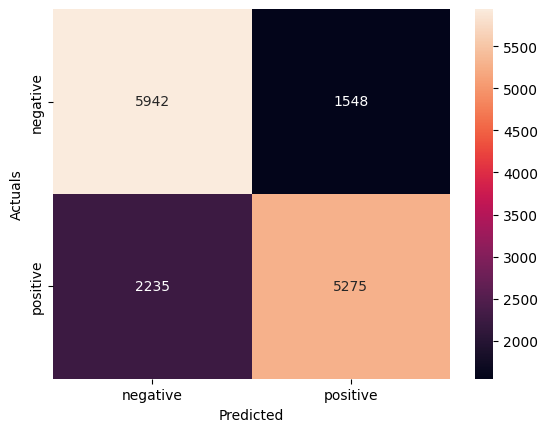

In [64]:
%matplotlib inline

cm = tf.compat.v1.confusion_matrix(test_sentiments, predictions)

LABELS = ['negative', 'positive']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

In [65]:
from sklearn.metrics import classification_report

print(classification_report(y_true=test_sentiments, y_pred=predictions, target_names=LABELS))

              precision    recall  f1-score   support

    negative       0.73      0.79      0.76      7490
    positive       0.77      0.70      0.74      7510

    accuracy                           0.75     15000
   macro avg       0.75      0.75      0.75     15000
weighted avg       0.75      0.75      0.75     15000

